# Training script for 3D reconstruction models

## Import of needed classes and functions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import gc
import time

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributed as dist
import zarr as z

from juart.conopt.functional.fourier import (
    fourier_transform_adjoint,
    fourier_transform_forward,
    nonuniform_fourier_transform_adjoint,
)
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.dl.checkpoint.manager import CheckpointManager
from juart.dl.loss.loss import JointLoss
from juart.dl.model.unrollnet import (
    LookaheadModel,
    UnrolledNet,
)
from juart.dl.operation.modules import training, validation
from juart.dl.utils.dist import GradientAccumulator
from juart.vis.interactive import InteractiveFigure3D

## Definition of the most important variables

In [2]:
# dataset options
nX, nY, nZ = 128, 128, 128  # Number of pixels in x-/y-/z-direction
kspace_cutoff = False  # defines if nX,... should be reduced
nX_cutoff, nY_cutoff, nZ_cutoff = 64, 64, 64  # defines nX,... for the cutoff state
nTI, nTE = 1, 1  # Number of measurements during the T1/T2 decay
shape = (nX, nY, nZ, nTI, nTE)  # Defining the shape later used for the model
nD = 1  # Number of subjects
nP = 20  # Number of slices per subject

# device options
device = "cuda:2"  # defines whether the model should be trained on the cpu or gpu
group = None
group_rank = 0
group_index = 0
num_groups = 1

# Training loop options
num_epochs = 20  # Number of epochs of the training
model_training = True  # Activate Training mode
model_validation = False  # Activate validation mode
save_checkpoint = (
    True  # Create save files that contain the current state of the training
)
checkpoint_frequency = 5  # Sets the number of iterations between creating save files
single_epoch = False  # Create a seperate save file after every single epoch
batch_size = 1  # Number of slices that should be used for training per batch

# model options
cgiter = 80
num_unroll_blocks = 10
activation = "ReLU"
features = 32
disable_progress_bar = False
kernel_size = (3, 3, 3)
axes = (1, 2, 3)
ResNetCheckpoints = True

# CheckpointManager Options
load_model_state = True  # Load the last saved model state
load_averaged_model_state = True  # Load the last saved averaged model state
load_optim_state = True  # Load the las saved optimizer state
load_metrics = True  # Load the last saved metrics (iterations and loss)
directory = (
    f"nummodel_test_{nP}P_{cgiter}DC_{num_epochs}E"  # Name that is used for the save directory of the model
)
root_dir = "/home/jovyan/models"  # path of the model directory
backend = "local"  # backend of the model directory

batch_size_local = batch_size // num_groups
num_iterations = nD * nP * num_epochs  # complete number of iterations
iteration = 0  # current iteration number

dtype = torch.complex64

In [3]:
if kspace_cutoff:
    nX, nY, nZ = nX_cutoff, nY_cutoff, nZ_cutoff
    shape = (nX, nY, nZ, nTI, nTE)

## Initializing worker groups

In [4]:
dist.init_process_group(
    backend="gloo", init_method="tcp://127.0.0.1:12345", world_size=1, rank=0
)

## Initializing the neural network
### Initializing the model
The model is the core of the neural network. Its forward pass describes the main steps of the neural network and the models features property describes the number of hidden features of the neural network and therefore its complexity. Furthermore the activation function and the number of iterations in dataconsistency term and regularization term is defined here.

In [5]:
model = UnrolledNet(
    shape,
    features=features,
    CG_Iter=cgiter,
    num_unroll_blocks=num_unroll_blocks,
    num_res_blocks = 10,
    activation=activation,
    disable_progress_bar=disable_progress_bar,
    timing_level=0,
    validation_level=0,
    kernel_size=kernel_size,
    axes=axes,
    ResNetCheckpoints = ResNetCheckpoints,
    device=device,
    dtype = dtype
)

### Initializing the loss function
The loss function defines how the difference between model prediction and correct result is calculated and it divides the loss into separate kinds of losses:
- kspace
- ispace
- wavelet
- hankel
- casorati

In [6]:
loss_fn = JointLoss(
    shape,
    3,
    weights_kspace_loss=(0.5, 0.5),
    weights_ispace_loss=(0.0, 0.0),
    weights_wavelet_loss=(0.0, 0.0),
    weights_hankel_loss=(0.0, 0.0),
    weights_casorati_loss=(0.0, 0.0),
    normalized_loss=True,
    timing_level=0,
    validation_level=0,
    group=group,
    device=device,
    dtype = dtype
)

### Initializing the optimizer
The optimizer determines which impact the calculated loss has on the models parameters. The impact can be variated via the learning rate lr.

In [7]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0001,
    betas=[0.9, 0.999],
    eps=1.0e-8,
    weight_decay=0.0
)

In [8]:
accumulator = GradientAccumulator(
    model,
    accumulation_steps=batch_size_local,
    max_norm=1.0,
    normalized_gradient=False
)

### Initializing the averaged model
The averaged model does not use the models parameters directly it uses the floating average of the model over the last n iterations. Its more robust than using the current average.

In [9]:
averaged_model = LookaheadModel(
    model,
    alpha=0.5,
    k=5
)

## Checkpoint Manager
### Initializing the CheckpointManager
The CheckpointManager is useful for saving and/or loading models. In this case here it either creates a new directory for the model or it loads data from an already existing directory to continue the training at the point where it lastly stopped.

In [10]:
checkpoint_manager = CheckpointManager(
    directory=directory,
    root_dir=root_dir,
    backend=backend,
)

#### Check if the model is already existing and load its last saved state

In [11]:
if load_model_state:
    print("Loading model state ...")
    checkpoint = checkpoint_manager.load(["model_state"], map_location=device)
    if all(checkpoint.values()):
        model.load_state_dict(checkpoint["model_state"])
    else:
        print("Could not load model state.")

Loading model state ...
Could not load model state.


#### Check if the averaged model is already existing and load its last saved state

In [12]:
if load_averaged_model_state:
    print(f"Loading averaged model state ...")
    checkpoint = checkpoint_manager.load(["averaged_model_state"], map_location=device)
    if all(checkpoint.values()):
        averaged_model.load_state_dict(checkpoint["averaged_model_state"])
    else:
        print("Could not load averaged model state.")

Loading averaged model state ...
Could not load averaged model state.


#### Check if the optimizer is already existing and load its last saved state

In [13]:
if load_optim_state:
    print("Loading optim state ...")
    checkpoint = checkpoint_manager.load(["optim_state"], map_location=device)
    if all(checkpoint.values()):
        optimizer.load_state_dict(checkpoint["optim_state"])
    else:
        print("Could not load optim state.")

Loading optim state ...
Could not load optim state.


In [14]:
total_trn_loss = list()
total_val_loss = list()
iteration = 0

#### Load the last saved state of the loss and the current iteration if existing

In [15]:
if load_metrics:
    print("Loading metrics ...")
    checkpoint = checkpoint_manager.load(["trn_loss", "val_loss", "iteration"])
    if all(checkpoint.values()):
        total_trn_loss = list(checkpoint["trn_loss"])
        total_val_loss = list(checkpoint["val_loss"])
        iteration = checkpoint["iteration"]
    else:
        print("Could not load metrics.")

Loading metrics ...
Could not load metrics.


In [16]:
print(f"Continue with iteration {iteration} ...")

Continue with iteration 0 ...


## Import the data that should be used for the training

In [17]:
# data_path = "3DLiss_vd_preproc.h5"
# with h5py.File(data_path, "r") as f:
#     print(f"Dataset holds following data: {f.keys()}")

#     print(f"Coilsensitivity info: {f['coilsens'].attrs['info']}")
#     print(f"Trajectory info: {f['k'].attrs['info']}")
#     print(f"Signal info: {f['d'].attrs['info']}")

#     shape = (156, 156, 156, 2)
#     ktraj = torch.from_numpy(f["k"][:])
#     coilsens = torch.from_numpy(f["coilsens"][:])
#     d = torch.from_numpy(f["d"][:])

#     print(f"Coilsensitivity shape {coilsens.shape}")
#     print(f"Trajectory shape {ktraj.shape}")
#     print(f"Signal shape {d.shape}")

In [18]:
store = z.open("/home/jovyan/datasets/num_phantom_128_R1")

C = torch.from_numpy(np.array(store["C"]))
k = torch.from_numpy(np.array(store["k"]))[...,None,None]
d = torch.from_numpy(np.array(store["d"]))[...,None,None]

coilsens = C

In [19]:
if kspace_cutoff == True:

    mask = torch.linalg.norm(ktraj, dim=0) <= nX_cutoff // 2

    ktraj = torch.stack(
        [ktraj[:, mask[:, echo], echo] for echo in range(ktraj.shape[2])], dim=-1
    )

    d = torch.stack([d[:, mask[:, echo], echo] for echo in range(d.shape[2])], dim=-1)

    coilsens_ksp = fourier_transform_forward(coilsens, axes=(1, 2, 3))
    low_lim, up_lim = int(156 / 2 - nX / 2), int(156 / 2 + nX / 2)
    coilsens_ksp = coilsens_ksp[:, low_lim:up_lim, low_lim:up_lim, low_lim:up_lim]
    coilsens = fourier_transform_adjoint(coilsens_ksp, axes=(1, 2, 3))

### shaping the data
#### In the next steps the data is formed into the right shape so that the training function will understand how the data is structured.

In [20]:
k_scaled = k / (2 * k.max())

generator = torch.Generator()

In [21]:
print(k_scaled.shape, coilsens.shape,d.shape)

torch.Size([3, 2097152, 1, 1]) torch.Size([8, 128, 128, 128]) torch.Size([8, 2097152, 1, 1])


## Actual training loop

In [22]:
while False:#iteration < num_iterations:
    print(f"iteration {iteration} / {num_iterations}")
    tic = time.time()
    
    generator = torch.Generator()
    
    generator.manual_seed(iteration%nP)

    kspace_mask_source = torch.randint(0, 2, (1, k_scaled.shape[1], 1, 1), generator=generator)
    kspace_mask_target = 1 - kspace_mask_source

    k_scaled_masked = k_scaled * kspace_mask_source
    print(k_scaled_masked.shape, d.shape)
    AHd = nonuniform_fourier_transform_adjoint(k_scaled_masked, d, (nX, nY, nZ))
    AHd = torch.sum(torch.conj(coilsens[..., None,None]) * AHd, dim=0)
    
    print(f'shapes:{AHd.shape}, {k_scaled.shape}, {coilsens.shape}, {d.shape}')
    
    data = [
        {
            "images_regridded": AHd,
            "kspace_trajectory": k_scaled,
            "sensitivity_maps": coilsens,
            "kspace_mask_source": kspace_mask_source,
            "kspace_mask_target": kspace_mask_target,
            "kspace_data": d,
        }
    ]

    # TRAINING
    if model_training:
        trn_loss = training(
            [0],
            data,
            model,
            loss_fn,
            optimizer,
            accumulator,
            group=group,
            device=device,
        )

        averaged_model.update_parameters(
            model,
        )

        torch.cuda.empty_cache()
        gc.collect()

    else:
        trn_loss = [0] * batch_size

    # VALIDATION
    if model_validation:
        val_loss = validation(
            validation_index,
            validation_data,
            averaged_model,
            loss_fn,
            group=group,
            device=device,
        )
        torch.cuda.empty_cache()
        gc.collect()

    else:
        val_loss = [0] * batch_size

    total_trn_loss += trn_loss
    total_val_loss += val_loss

    # SAVING
    # Completed epoch
    if save_checkpoint and np.mod(iteration + batch_size, nD * nP) == 0:
        print("Creating tagged checkpoint ...")

        checkpoint = {
            "iteration": iteration + batch_size,
            "model_state": model.state_dict(),
            "averaged_model_state": averaged_model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "trn_loss": total_trn_loss,
            "val_loss": total_val_loss,
        }

        epoch = (iteration + batch_size) // (nD * nP)
        checkpoint_manager.save(checkpoint, tag=f"_epoch_{epoch}")

        if single_epoch:
            # Also save the checkpoint as untagged checkpoint
            # Otherwise, training will be stuck in endless loop
            checkpoint_manager.save(checkpoint)
            checkpoint_manager.release()
            break

    # Intermediate checkpoint
    elif save_checkpoint and np.mod(iteration + batch_size, checkpoint_frequency) == 0:
        print("Creating untagged checkpoint ...")

        checkpoint = {
            "iteration": iteration + batch_size,
            "model_state": model.state_dict(),
            "averaged_model_state": averaged_model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "trn_loss": total_trn_loss,
            "val_loss": total_val_loss,
        }

        checkpoint_manager.save(checkpoint, block=False)

    toc = time.time() - tic

    print(
        (
            f"Iteration: {iteration} - "
            + f"Elapsed time: {toc:.0f} - "
            + f"Training loss: {[f'{loss:.3f}' for loss in trn_loss]} - "
            + f"Validation loss: {[f'{loss:.3f}' for loss in val_loss]}"
        )
    )

    torch.cuda.empty_cache()
    gc.collect()

    iteration += batch_size
    print(f"current iteration: {iteration}")

In [23]:
generator = torch.Generator()
generator.manual_seed(0)

kspace_mask_source = torch.randint(0, 2, (1, k.shape[1], 1, 1), generator=generator)
kspace_mask_target = 1 - kspace_mask_source
k_masked = k * kspace_mask_source

AHd = nonuniform_fourier_transform_adjoint(k_masked, d, (nX, nY, nZ))
AHd = torch.sum(torch.conj(C[..., None,None]) * AHd, dim=0)

data = [
    {
        "images_regridded": AHd,
        "kspace_trajectory": k,
        "sensitivity_maps": C,
        "kspace_mask_source": kspace_mask_source,
        "kspace_mask_target": kspace_mask_target,
        "kspace_data": d,
    }
]


trn_loss, image = training(
    [0],
    data,
    model,
    loss_fn,
    optimizer,
    accumulator,
    group=group,
    device=device,
)

Rank 0 - reading data
Rank 0 - reading data done -> model initialization


100%|██████████| 10/10 [01:27<00:00,  8.71s/it]


Rank 0 - model initialization done -> loss fn initialization
[KSpaceLoss] torch.Size([8, 2097152, 1, 1]) torch.Size([8, 2097152, 1, 1]) None
Rank 0 - Loss k-space: 6.428 - Loss image space: 0.000 - Loss Wavelet 0.000 - Loss Hankel 0.000 - Loss Casorati 0.000
Rank 0 - loss fn initialization done -> compute backward pass
Rank 0 - compute backward pass done -> compute accumulator
Rank 0 - Index 0 - Gradient norm: 1249.134
Averaged gradient norm: 1.000


interactive(children=(IntSlider(value=64, description='Dimension 3', max=128, min=1), Output()), _dom_classes=…

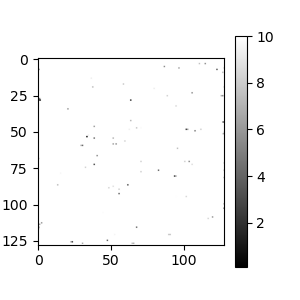

In [24]:
InteractiveFigure3D(
    image[...,0,0].cpu().abs().detach().numpy(),
    cmap='gray',
    vmax=10
).interactive